# ML with Large Datasets
----
## Dataset Description
In order to explore these Spark API, we use the [following dataset](). The data is from a population and housing census of some country ```X```  not identified for privacy reasons although this data is a very small subset of the actual data. 
Each row in the data represent a single individual in the population. 
 A summary of column description is provided below:
- **Geographic identifiers:** PROVINCE, REGION, DISTRICT, COMMUNE,MILIEU ,
       IDMEN, IDINDIV. This type of data has a somewhat hierarchical structure. We have a household (think of it as family), IDMEN-household ID. Within each household, we have individuals, IDINDIV - individual
       > 
- **MILIEU:** A classification of whether this person lived in urban or rural area. ```2-Rural, 1-Urban```
- **Sex**. ```P05```==>[1	- Male 2	- Female]
- **P19 Languages spoken**. What languages the person can speak.This variable is split into 4 variables as follows: ```P19MG, P19FR, P19AN, P19AU``` for local language, English, French and any other language.
- **P20, Literacy**. Whether the person can read and write any of the 3 languages given. Note that there three variables each representing each language. A local language, French and English. For each language, the value 1 means they can read and write in the language while 2 means they cannot.The variables are ```P20MG (local language), P20FR (French), P20AN (English), P20AU (other)```. 
- **P03:** whether the person is the head of the household, wife. child etc==>[0- Chef de Ménage (CM) 1- Conjoint(e) (CJ) 2-	Fils/Fille3-	Père/Mère 4-	Beau-Père/Belle-Mère 5-	Beau-Fils/Belle-Fille 6-	Petit fils/Petite-fille
 Autre Proche du CM 8- Autre proche du CJ 9 -Sans lien de parenté]

- **Age:**. Person's date of birth is given by column ```P07M``` (month of birth), ```P07A``` (year of birth) and ```P08``` (age)
- **Marital status:** ```P28``` (whether the person is married or not)==>[1-	Célibataire, 2-	Marié(e), 3-	Divorcé(e)/Séparé(e), 4-	Veuf(ve)]. This question is asked to residents who are 12 years or older. 
- **Age at first marriage**. ```P29``` (age at marriage).The question was like this: How old was <NAME> when he/she got married for the first time?
- **School attendance:** ```P21``` ==>[0 N'a Jamais fréquenté 1-A	fréquenté 2- Fréquente actuellement]
- **Highest school level attended:**```P22N```. This variable represents highest level of school attended. The question was asked like this: What is the highest level of education that (name) achieved during his studies?
 > 1. Preschool; 2. Primary-school; 3. Secondary; 4. Technical college; 5. University 
 - **Number of years of school completed at a particular level:** ```P22C``` Years completed at that level. A value of 0 means the person didnt complete the first year of education at that level. 
 > Preschool(0-2); Primary-school(0-5);Secondary(0-7); Technical college (0-7); University (0-7)
 
- **Whether the person worked or not:** ```P23```==> [1-	0ccupé 2-	Chômeur 3-	En quête du 1er emploi 4-	Ménagère 5-	Elève/Etudiant 6-	Retraité 7- lncapacité à travailler 8- Autre]

## The Task
The Ministry of Health in the country has expressed concern about the prevalence of early marriages among young individuals (both men and women). They have tasked you with investigating the factors contributing to early marriages. For the purpose of this analysis, individuals who get married at the age of 18 or younger are classified as having married early or belonging to the early marriage category. Beyond conducting exploratory analysis, the Ministry has requested that you develop a model to predict whether a person is likely to marry young, based on factors such as place of residence, household size, parents' education levels, and other relevant variables. In summary, these are the project goals.
1. Perfom explotaory analysis to understand early marriages 
2. Build a Machine Learning model which can predict whether a person will get married early or not.
3. Report on the model performance and efficacy

## Python setup

In [18]:
## Python setup
from datetime import datetime
from IPython.display import Image
import pandas as pd
# Suppress scientific notation globally
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate

# Inputs Paths, Global Variables and Parameters
Lets provide paths to input files we will use. 
Its a good practice to create these as global variables. Also, use Python module ```Path``` from pathlib to manage file paths. 

In [19]:
# path to hh_data.txt
HH_DATA = "/home/manuella/Desktop/BDA/final_project/population-project-dataset/ResidentIBEIPM.csv"

# Decide which columns to keep
COLS_TO_KEEP = ['IDMEN', 'IDINDIV','PROVINCE','REGION','DISTRICT','COMMUNES','MILIEU', 'P05',  'P20MG', 'P20FR',
                'P20AN', 'P20AU', 'P03', 'P07M', 'P07A', 'P08', 'P28', 'P29', 'P21', 'P22N', 'P22C', 'P23', 'P19MG',
                'P19FR', 'P19AN', 'P19AU']

# Regular household size threshold
# use quintiles to determine the threshold
HH_SIZE_THRESHOLD = 0.99

# CHILFREN AGE THRESHOLD
CHILDREN_AGE_THRESHOLD = 15
ELDERY_AGE_THRESHOLD = 65
EARLY_MARRIAGE_AGE_THRESHOLD = 18
    

In [20]:
spark = SparkSession.builder\
                .appName("LargeDatasetProcessing")\
                .master(f"local[8]")\
                .config("spark.driver.memory", "8g")\
                .config("spark.executor.memory", "8g")\
                .config("spark.memory.offHeap.enabled", "true")\
                .config("spark.sql.shuffle.partitions", "8")\
                .config("spark.memory.offHeap.size", "1g")\
                .config("spark.driver.bindAddress", "127.0.0.1") \
                .getOrCreate()

# Task-1-Loading and subsetting data 


### 1- Strategy for loading the data. Since the dataset is 16GB, its not recommended to work with the whole dataset. Please provide your strategy/plan for efficiently loading the data and working with it through the project. [200]


To efficiently handle the large dataset (16GB) I implement the following strategic approach for loading and processing the data :


   - **Column Selection**:
        Identify and retain only the necessary columns that will be used for analysis. This identification is based on the dataset description. This reduces memory usage and speeds up processing. For this project, the columns selected in COLS_TO_KEEP are appropriate, as they likely contain relevant demographic and household information to help us in our task.
        
   - **Data Loading with Spark**:
        Utilize Apache Spark for loading the dataset, as it can handle large datasets efficiently. Use the spark.read.csv function to read the data in parallel, which is particularly useful for large files.
        
   - **Repartitioning and Writing Data**:
        Repartition the DataFrame to optimize performance during processing. Write the filtered data back to a smaller CSV file, which will be easier to work with in subsequent analyses.
        
   - **Loading into Pandas**:
        Once the smaller dataset is created, load it into a pandas DataFrame for further analysis. This allows for easier manipulation and exploration of the data.


### 2- Implementation of the strategy

# Preprocess the Data

The objective here is to load the dataset, retain only the necessary columns to reduce its size, and enable faster processing. During preprocessing, we aim to clean up the columns and convert numeric columns into proper numeric data types.

## Load the Data

I use Spark for loading the data because it is faster than pandas. Alternatively, students can use the pandas "chunk" method to load data in manageable chunks. Another approach is to first load a small sample of the dataset, identify and document the required columns, and then load only those columns from the full dataset.

## Subset the Columns

Whether or not all columns were initially loaded, this step involves selecting only the required columns for further processing.

## Preprocess and Clean Data

For columns such as `age`, ensure they are in numeric format. Rows containing invalid or erroneous data can be removed as part of the cleaning process.


In [5]:
sdf = spark.read.csv(HH_DATA, header=True, sep=",", inferSchema=True)

## Subset the Data
Keep only the columns we need and save a smaller dataset.

In [6]:
sdf2 = sdf.select(COLS_TO_KEEP)

In [7]:
# Repartition the DataFrame to 10 partitions
out_csv = "/home/manuella/Desktop/BDA/final_project/population-project-dataset/proj-dataset-small"

sdf2.repartition(10).coalesce(1).write.csv(out_csv, header=True, sep=",", mode="overwrite")

## Task 2 : Data Preprocessing
- Rename columns for easy identification
- Perform data type conversion if necessary

 The goal of this part is to preprocess a large dataset into a format suitable for building predictive models. This involves cleaning the data, handling missing values, creating additional features, and ensuring that the dataset is manageable in size while retaining the necessary information. To do that we follow these steps:

   - **Loading the Data**:
        We load the small dataset, keeping only the columns that are essential for analysis. This helps in reducing memory usage and speeds up processing.

   - **Renaming Columns**:
        Rename columns to more meaningful names for better understanding and easier reference throughout the analysis. This will improve code readability and maintainability.
        
   - **Generating Additional Variables**:
        Create new variables that are essential for analysis, such as household size, the number of children, and the number of elderly individuals in each household. This will provide a richer dataset for modeling.

   - **Merging DataFrames**:
        After generating household-level variables, merge them back into the main DataFrame. This ensures that all relevant information is consolidated for subsequent analysis.


   - **Data Type Conversion**:
        Ensure that data types are appropriate for analysis. Convert categorical variables to the appropriate data type (e.g., using pd.Categorical) and ensure numerical types are correctly set for model training.





In [6]:
# ==========================================================
# Load the smaller CSV fwe just created as pandas DataFrame
# ==========================================================
df = pd.read_csv("/home/manuella/Desktop/BDA/final_project/population-project-dataset/proj-dataset-small/part-00000-d50d9bae-3d77-4f8e-9dc4-52357abeb6c2-c000.csv")
df.head(10)

,IDMEN,IDINDIV,PROVINCE,REGION,DISTRICT,COMMUNES,MILIEU,P05,P20MG,P20FR,...,P28,P29,P21,P22N,P22C,P23,P19MG,P19FR,P19AN,P19AU
0,11101101040031016022490249,1110110104003011602490224901,1,11,111,11101,1,2,1.00,1.00,...,4.00,14.00,1.00,3.00,4.00,4.00,1.00,1.00,2.00,2.00
1,11101101380021100021410141,1110110138002110001410214106,1,11,111,11101,1,2,1.00,1.00,...,1.00,NaN,1.00,5.00,3.00,3.00,1.00,1.00,1.00,2.00
2,11101101380051116023320332,1110110138005111603320233203,1,11,111,11101,1,2,1.00,1.00,...,4.00,22.00,1.00,3.00,2.00,4.00,1.00,1.00,2.00,2.00
3,11101101330031127021180118,1110110133003112701180211802,1,11,111,11101,1,2,1.00,1.00,...,2.00,17.00,1.00,4.00,2.00,1.00,1.00,1.00,1.00,2.00
4,11101101400041156020220022,1110110140004115600220202204,1,11,111,11101,1,2,1.00,1.00,...,1.00,NaN,2.00,3.00,1.00,5.00,1.00,1.00,1.00,2.00
5,11101101120051095020150015,1110110112005019500150201503,1,11,111,11101,1,1,1.00,1.00,...,NaN,NaN,2.00,2.00,3.00,5.00,1.00,1.00,2.00,2.00
6,11101101150051104022690269,1110110115005110402690226902,1,11,111,11101,1,2,1.00,1.00,...,2.00,18.00,1.00,2.00,5.00,4.00,1.00,2.00,2.00,2.00
7,11101101120061094023150315,1110110112006019403150231502,1,11,111,11101,1,2,1.00,2.00,...,2.00,19.00,1.00,3.00,1.00,1.00,1.00,2.00,2.00,2.00
8,11101101020041093022010201,1110110102004019302010220106,1,11,111,11101,1,1,2.00,2.00,...,NaN,NaN,2.00,2.00,1.00,5.00,1.00,2.00,2.00,2.00
9,11101101020041034020100010,1110110102004013400100201002,1,11,111,11101,1,2,1.00,1.00,...,2.00,27.00,1.00,3.00,3.00,1.00,1.00,1.00,2.00,2.00


In [7]:
# ====================================
# RENAME COLUMNS
# ====================================
# Rename the columns to more meaningful names for easy understanding and ide

NEW_COLS = {'IDMEN': 'hh_id', 'IDINDIV': 'id_indiv','PROVINCE': 'id_province','REGION': 'id_region','DISTRICT': 'id_district','COMMUNES': 'id_commune',
            'MILIEU': 'id_milieu', 'P05': 'sex',  'P20MG':'read_local_lang', 'P20FR': 'read_french',
            'P20AN':  'read_english', 'P20AU': 'read_other', 'P03': 'hh_head', 'P07M': 'month_birth', 'P07A': 'year_birth', 
            'P08': 'age', 'P28': 'marital_status', 
            'P29': 'age_first_marriage', 'P21': 'school_attendance', 'P22N': 'school_level', 'P22C': 'nb_years_school', 
            'P23': 'work', 'P19MG': 'speak_local_lang',
                'P19FR': 'speak_french', 'P19AN': 'speak_english', 'P19AU': 'speak_other'}

df.rename(columns= NEW_COLS, inplace = True)
df.head()

,hh_id,id_indiv,id_province,id_region,id_district,id_commune,id_milieu,sex,read_local_lang,read_french,...,marital_status,age_first_marriage,school_attendance,school_level,nb_years_school,work,speak_local_lang,speak_french,speak_english,speak_other
0,11101101040031016022490249,1110110104003011602490224901,1,11,111,11101,1,2,1.00,1.00,...,4.00,14.00,1.00,3.00,4.00,4.00,1.00,1.00,2.00,2.00
1,11101101380021100021410141,1110110138002110001410214106,1,11,111,11101,1,2,1.00,1.00,...,1.00,NaN,1.00,5.00,3.00,3.00,1.00,1.00,1.00,2.00
2,11101101380051116023320332,1110110138005111603320233203,1,11,111,11101,1,2,1.00,1.00,...,4.00,22.00,1.00,3.00,2.00,4.00,1.00,1.00,2.00,2.00
3,11101101330031127021180118,1110110133003112701180211802,1,11,111,11101,1,2,1.00,1.00,...,2.00,17.00,1.00,4.00,2.00,1.00,1.00,1.00,1.00,2.00
4,11101101400041156020220022,1110110140004115600220202204,1,11,111,11101,1,2,1.00,1.00,...,1.00,NaN,2.00,3.00,1.00,5.00,1.00,1.00,1.00,2.00


### Add New Variables We Need

In some cases, key information we need to explore may not be readily available in the dataset. For example, to analyze households, we might need to create a new column to represent household size.

#### Household Size
Household size refers to the number of people in a household. The dataset provides a household identifier (`hh_id`) and an individual identifier (`indiv_id`). Using these, we can generate a new column called `household_size`.

#### Feature Engineering: Creating Additional Variables
Feature engineering is the process of transforming raw data into meaningful features that improve the performance of machine learning models. This involves selecting, creating, modifying, or aggregating data attributes to make them more informative and relevant to the task at hand. Feature engineering is inherently a creative task—there are no strict rules. As a data scientist or machine learning practitioner, it's up to you to explore the data, consult domain experts, and study relevant literature to design and test new features.

For this analysis, we can consider creating the following features, which may influence the age at first marriage:

- **Number of dependent children in the household**: Defined as the number of individuals aged 15 and younger.
- **Number of dependent adults in the household**: Defined as the number of individuals aged 65 and older.

#### Household Level Variables 
Note that we have two levels of analysis units here: the individual and the household. As such, variables such as household size, number of children, number of the eldery are all household level variables. Since the head of the family or head of the household has more power in determing what happens in the house, we can also add household head variables. Concretely, for each household, we can have variables named like this: hoh_age, hoh_educ, hoh_literacy etc.

In [8]:
import pandas as pd

def gen_var_hh_size(df, hh_id_col='hh_id'):
    """Generates household-level variables including size, number of children, and elderly individuals."""
    
    # ======================================================
    # GENERATE HH SIZE
    # ======================================================
    hh_size = df.groupby(hh_id_col).size().reset_index(name='hh_size')

    # ======================================================
    # GENERATE NUMBER OF CHILDREN AND ELDERLY
    # ======================================================
    children = df[df['age'] <= 15].groupby(hh_id_col).size().reset_index(name='num_children')
    elderly = df[df['age'] >= 65].groupby(hh_id_col).size().reset_index(name='num_elderly')

    # ======================================================
    # MERGE THE DATAFRAMES
    # ======================================================
    merged_df = pd.merge(hh_size, children, on=hh_id_col, how='left')
    merged_df = pd.merge(merged_df, elderly, on=hh_id_col, how='left')

    # ======================================================
    # FILL NAs WITH 0
    # ======================================================
    merged_df.fillna({'num_children': 0, 'num_elderly': 0}, inplace=True)

    # ======================================================
    # CHECK THAT WE HAVE ALL HH_ID
    # ======================================================
    # Ensure that all household IDs are present
    total_hh_id_count = df[hh_id_col].nunique()
    distinct_hh_id_count = merged_df[hh_id_col].nunique()
    assert total_hh_id_count == distinct_hh_id_count, "Household IDs are not present."

    # Generate household head variables
    hoh_df = df[df['hh_head'] == 0].groupby(hh_id_col).agg(
        hoh_age=('age', 'first'),
        hoh_educ=('nb_years_school', 'first'),
        hoh_literacy=('read_local_lang', 'first')
    ).reset_index()

    # Merge household head variables
    merged_df = pd.merge(merged_df, hoh_df, on=hh_id_col, how='left')

    return merged_df

In [9]:
# ====================================
# ADD HOUSEHOLD LEVEL VARIABLES
# ====================================
# Household size
df_hh = gen_var_hh_size(df)

# Merge household size back to the main dataframe
df = df.merge(df_hh, on='hh_id', how='left')

In [10]:
df.head()

,hh_id,id_indiv,id_province,id_region,id_district,id_commune,id_milieu,sex,read_local_lang,read_french,...,speak_local_lang,speak_french,speak_english,speak_other,hh_size,num_children,num_elderly,hoh_age,hoh_educ,hoh_literacy
0,11101101040031016022490249,1110110104003011602490224901,1,11,111,11101,1,2,1.00,1.00,...,1.00,1.00,2.00,2.00,5,3.00,0.00,30.00,4.00,1.00
1,11101101380021100021410141,1110110138002110001410214106,1,11,111,11101,1,2,1.00,1.00,...,1.00,1.00,1.00,2.00,6,0.00,0.00,60.00,3.00,1.00
2,11101101380051116023320332,1110110138005111603320233203,1,11,111,11101,1,2,1.00,1.00,...,1.00,1.00,2.00,2.00,4,1.00,0.00,28.00,7.00,1.00
3,11101101330031127021180118,1110110133003112701180211802,1,11,111,11101,1,2,1.00,1.00,...,1.00,1.00,1.00,2.00,4,2.00,0.00,31.00,5.00,1.00
4,11101101400041156020220022,1110110140004115600220202204,1,11,111,11101,1,2,1.00,1.00,...,1.00,1.00,1.00,2.00,4,1.00,0.00,21.00,1.00,1.00


# TASK3 -  Explolatory Data Analysis (EDA)
Before any ML task, its important to understand the data. 
This is done by exploring the data to understand the data types, missing values, and the distribution of the data. This is important as it helps in understanding the data and the features that can be used in the ML model.

## Histogram of age at first marriage


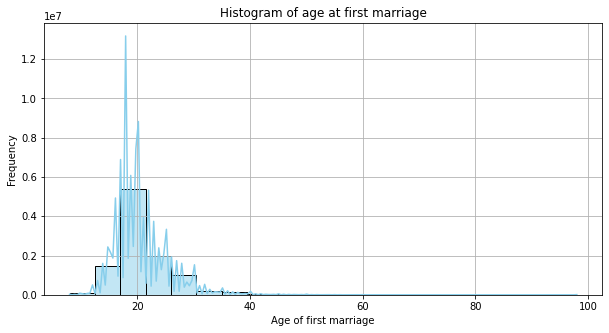

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot : Histogram of age at first marriage
plt.figure(figsize=(10, 5))
sns.histplot(df['age_first_marriage'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of age at first marriage')
plt.xlabel('Age of first marriage')
plt.ylabel('Frequency')
plt.grid()
plt.show()






**Interpretation**:

   The histogram suggests a potential bimodal distribution, with noticeable peaks at different age ranges (around 20 and again in the late 30s), indicating different cultural or social patterns in marriage timing.
    The initial peak at younger ages could reflect cultural norms favoring early marriage, while the second peak may represent individuals who marry later, possibly reflecting changing societal norms or personal choices.

   The tail of the distribution extends into older ages, showing a gradual decline in frequency as age increases. There are few individuals marrying for the first time after the age of 40.
    This tail behavior highlights that while early marriage is common, later marriages are less frequent, suggesting societal shifts regarding marriage timing.



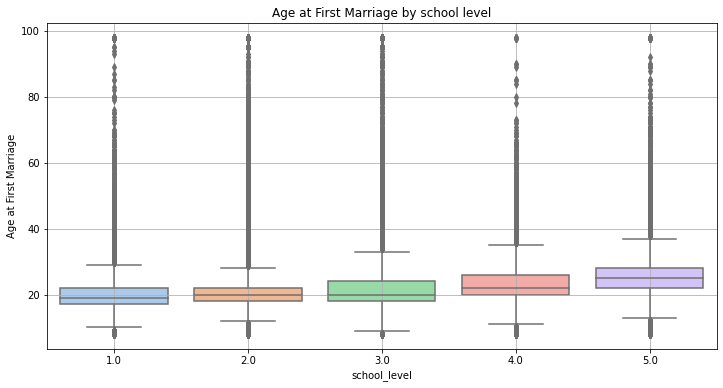

In [12]:
# Plot : Box Plot of Age at First Marriage by id_milieu
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='school_level', y='age_first_marriage', palette='pastel')
plt.title('Age at First Marriage by school level')
plt.xlabel('school_level')
plt.ylabel('Age at First Marriage')
plt.grid()
plt.show()





**Interpretation**:

   As the school level increases, the median age at first marriage tends to rise. This suggests that individuals with higher educational attainment generally marry later.
    The spread of ages (IQR) also appears to be wider at lower education levels, indicating more variability in age at first marriage among those with less education.



   There are several outliers across all education levels, particularly noticeable in the lower school levels. This indicates that while most individuals marry at younger ages, some marry significantly later, regardless of their education level.
    The presence of outliers suggests that individual circumstances greatly affect marriage timing, potentially influenced by cultural, economic, or personal factors.



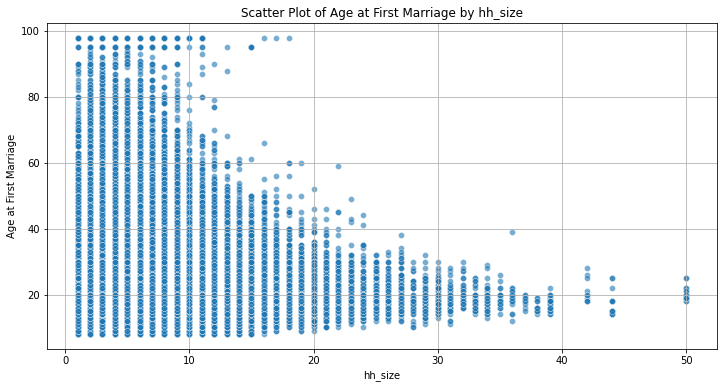

In [13]:
# Scatter Plot of Age at First Marriage by household size
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='hh_size', y='age_first_marriage', alpha=0.6)
plt.title('Scatter Plot of Age at First Marriage by hh_size')
plt.xlabel('hh_size')
plt.ylabel('Age at First Marriage')
plt.grid()
plt.show()



   **Interpretation**:
   
   There appears to be a negative correlation between household size and age at first marriage. As household size increases, the age at which individuals marry for the first time tends to decrease.
        This trend suggests that individuals from larger households may marry at younger ages, which could be influenced by cultural, economic, or social factors.

    
   The density of points is higher at younger ages (below 30) and gradually decreases as age increases, indicating that fewer individuals marry for the first time at older ages.
       There are some outliers, particularly at larger household sizes where individuals marry at ages around 30 to 50, suggesting that exceptions to the trend exist.

    

In summary, this scatter plot effectively illustrates the relationship between age at first marriage and household size, highlighting a potential negative correlation while providing insights into the trends and distributions of the data.

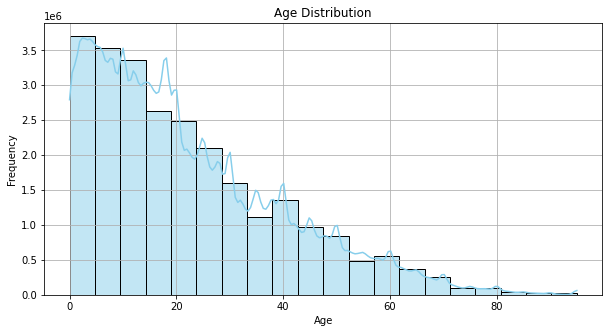

In [14]:
# Plot : Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()





**Interpretation:**

  The distribution appears to be right-skewed, with a higher frequency of younger individuals and a gradual decline in frequency as age increases.
    
   The ages from 0 to around 30 years show a significant concentration of individuals, suggesting a younger demographic in 

   The tail of the distribution extends into older ages (60+), but the frequency of individuals decreases sharply, indicating fewer older individuals in the dataset.
    
   This could reflect demographic trends or sampling biases and may warrant further investigation.



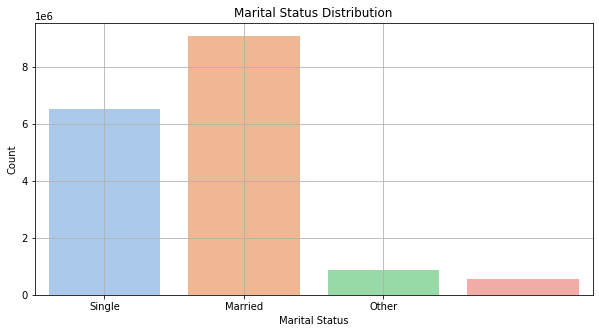

In [15]:
# Plot : Marital Status Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='marital_status', palette='pastel')
plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Single', 'Married', 'Other'])  # Adjust labels as needed
plt.grid()
plt.show()



Distribution Insights:

   The largest bar corresponds to the "Married" category, indicating that this is the most common marital status among the individuals in the dataset, with a count of nearly 1 million.
    The "Single" category follows, with a substantial count but significantly lower than that of the married individuals.
    The "Other" category has the smallest count, suggesting that fewer respondents identify with statuses outside of single or married.

In summary, the plot effectively communicates the distribution of marital status, highlighting the predominance of married individuals in the dataset while providing a clear visual comparison among the categories.


# TASK4 - Prepare Data for ML

### 1 - Identify and prepare target variable for prediction


### 2-Decide which features to start with. For example, age, household head status, marital status, literacy, languages spoken, province, region, district.

### 3- For categorical variables, use one-hot encoding to convert them into numeric variables 

### 4- Do you think its a good idea to add communes? Please explain your reasoning.
At the end of this process, you will end up with a dataframe with around 10 millio rows and over 150 columns (due to one-hot encoding)


## Generate Target Variable for Prediction

The goal of this project is to  predict whether a person will get married early or not.
For that reason our target variable for prediction is EARLY MARRIAGE



In [21]:
# ====================================
# ADD EARLY MARRIAGE VARIABLE
# ====================================
# if age_married < 18, then early_marriage = 1
df['early_marriage'] = df['age_first_marriage'].apply(lambda x: 1 if x < EARLY_MARRIAGE_AGE_THRESHOLD else 0)

## Drop Observations
- In this datasets, the marriage variabels are available for all individuals who are 12 years old or older. We can drop the observations where the marriage status is not available.
- Age at first marriage also makes sense for people who are currently married, divorced or widowed.

In [30]:
# Keep only individuals who are 12 years and above
df_marr = df[df['age'] >= 12]

In [31]:
# Keep only individuals who were ever married (currently married, divorced or widowed)
df_marr = df_marr[df_marr['marital_status'] != 1]

## Features for Prediction

According to our data exploration we have been able to identify some features correlated to the age of first marriage.

For that reason we choose for our work the 12 following features: **'num_elderly', 'age', 'hh_size', 'num_children', 'sex', 'marital_status', 'id_province', 'id_region', 'id_district', 'school_level' and 'work'**.

Some features like **age of first marriage** are not consider because it help to obtain our target variable

I think it's not a good idea to add commune because we have already the province, region and district and we can find the commune using these features,

In [32]:
# Assuming `df` is your DataFrame
column_types = df_marr.dtypes
print(column_types)

hh_id                  object
id_indiv               object
id_province             int64
id_region               int64
id_district             int64
id_commune              int64
id_milieu               int64
sex                     int64
read_local_lang       float64
read_french           float64
read_english          float64
read_other            float64
hh_head                 int64
month_birth             int64
year_birth              int64
age                   float64
marital_status        float64
age_first_marriage    float64
school_attendance     float64
school_level          float64
nb_years_school       float64
work                  float64
speak_local_lang      float64
speak_french          float64
speak_english         float64
speak_other           float64
hh_size                 int64
num_children          float64
num_elderly           float64
hoh_age               float64
hoh_educ              float64
hoh_literacy          float64
early_marriage          int64
dtype: obj

In [33]:
def convert2int(x):
    try:
        # Check if value is a float and has no decimal part
        if isinstance(x, float) and x.is_integer():
            return int(x)
        elif isinstance(x, int):  # Handle integers directly
            return x
        else:
            return np.nan  # Return NaN for anything else
    except:
        return np.nan

In [34]:
# ====================================
# PREPARE DATA FOR ML MODELS
# ====================================
# Create a new DataFrame with the selected features


# Define numerical and categorical columns
numericals = ['num_elderly', 'age', 'hh_size', 'num_children']
categorical_columns = ['sex', 'marital_status', 'id_province', 'id_region', 'id_district', 'school_level',
                       'work', 'early_marriage']
new_df = df_marr[numericals + categorical_columns].copy()
# Function to convert to integer (modify as needed for your data)
# def convert2int(value):
#     return int(value) if pd.notnull(value) else None

# Convert columns with categorical data to pd.category type
for col in categorical_columns:
    if col in new_df.columns:
        new_df[col] = new_df[col].apply(convert2int)

# Target variable for prediction
y = new_df['early_marriage'] if 'early_marriage' in new_df.columns else None

# Features to use for prediction
X = new_df.drop(columns=['early_marriage'], errors='ignore')

# Set categorical features to pd.Categorical
for col in categorical_columns:
    if col in X.columns:
        X[col] = pd.Categorical(X[col])

# Convert target variable to categorical if it exists
if y is not None:
    y = pd.Categorical(y)

# Verify the changes
print(X.head())
if y is not None:
    print(y)

# Verify the DataFrame structure
print("Features in X:", X.columns.tolist())
print("Target variable y:", y)

   num_elderly   age  hh_size  num_children sex marital_status id_province  \
0         0.00 30.00        5          3.00   2              4           1   
2         0.00 48.00        4          1.00   2              4           1   
3         0.00 31.00        4          2.00   2              2           1   
6         0.00 49.00        7          4.00   2              2           1   
7         0.00 41.00        6          2.00   2              2           1   

  id_region id_district school_level work  
0        11         111         3.00    4  
2        11         111         3.00    4  
3        11         111         4.00    1  
6        11         111         2.00    4  
7        11         111         3.00    1  
[1, 0, 1, 0, 0, ..., 1, 1, 0, 0, 1]
Length: 10514495
Categories (2, int64): [0, 1]
Features in X: ['num_elderly', 'age', 'hh_size', 'num_children', 'sex', 'marital_status', 'id_province', 'id_region', 'id_district', 'school_level', 'work']
Target variable y: [1, 0, 1

In [35]:
# ====================================
# DEAL WITH MISSING VALUES
# ====================================
# Fill missing values with the mode for categorical variables
# and mean/median for continuous variables

for col in numericals:
    if col in X.columns and X[col].isnull().any():  # Check for missing values
        mean_value = X[col].mean()  # Calculate mean
        X[col].fillna(mean_value, inplace=True) 

# Ensure 'X' contains only categorical columns defined in 'categorical_columns'
for col in categorical_columns:
    if col in X.columns and X[col].isnull().any():  # Check for missing values
        mode_value = X[col].mode()[0]  # Calculate mode
        X[col].fillna(mode_value, inplace=True)  

# Verify that there are no missing values left
print(X.isnull().sum())


num_elderly       0
age               0
hh_size           0
num_children      0
sex               0
marital_status    0
id_province       0
id_region         0
id_district       0
school_level      0
work              0
dtype: int64


In [36]:
# ============================================
# DEAL WITH OUTLIERS IN CONTINUOUS VARIABLES
# =============================================
# Display the original size of the DataFrame
print("Original DataFrame size:", new_df.shape)

# Drop outliers based on the defined thresholds
new_df = new_df[(new_df['age'] <= 100) &
                 (new_df['hh_size'] <= 20) &
                 (new_df['num_children'] <= 15) &
                 (new_df['num_elderly'] <= 15)]

# Display the new size of the DataFrame after dropping outliers
print("New DataFrame size after dropping outliers:", new_df.shape)

# Verify the changes
print(new_df.shape)

Original DataFrame size: (10514495, 12)
New DataFrame size after dropping outliers: (10510511, 12)
(10510511, 12)


In [37]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================
# One-hot encode the categorical variables
# using pd.get_dummies function
# Make sure you one-hot encode all the categorical variables

# One-hot encode categorical variables
new_df = pd.get_dummies(new_df, columns=categorical_columns, drop_first=True)

# Display the first few rows of the new DataFrame
print(new_df.shape)

# Verify the DataFrame structure
print("New DataFrame columns:", new_df.columns.tolist())

(10510511, 158)
New DataFrame columns: ['num_elderly', 'age', 'hh_size', 'num_children', 'sex_2', 'marital_status_3', 'marital_status_4', 'id_province_2', 'id_province_3', 'id_province_4', 'id_province_5', 'id_province_6', 'id_region_12', 'id_region_13', 'id_region_14', 'id_region_21', 'id_region_22', 'id_region_23', 'id_region_24', 'id_region_25', 'id_region_31', 'id_region_32', 'id_region_33', 'id_region_41', 'id_region_42', 'id_region_43', 'id_region_44', 'id_region_51', 'id_region_52', 'id_region_53', 'id_region_54', 'id_region_61', 'id_region_62', 'id_district_112', 'id_district_113', 'id_district_114', 'id_district_115', 'id_district_116', 'id_district_117', 'id_district_118', 'id_district_121', 'id_district_122', 'id_district_123', 'id_district_124', 'id_district_125', 'id_district_126', 'id_district_127', 'id_district_131', 'id_district_132', 'id_district_133', 'id_district_141', 'id_district_142', 'id_district_211', 'id_district_212', 'id_district_213', 'id_district_214', 'id_

# Task-5-Build ML Model with Scikit-learn and spark

### Use sklearn to compare perfomance of the following models: Logistic regression, random forest and gradient boosted trees. Report on the accuracy of each of these models. One of your models need to reach accuracy of at least 80%. Make sure you use parameter “n_jobs=-1” to utilize all cores on your computer. Please make sure the print out from the model evaluation is available in the notebook for the tutors to see. 


In [ ]:
def random_forest_with_sklearn(df, num_estimators=100):
    # Define the target variable and features
    target_var = 'early_marriage_1'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    #X = df[features]
    #y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=num_estimators, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    return rf_model

In [43]:
def evaluate_models_sklearn(df):
    # Define the target variable and features
    target_var = 'early_marriage_1'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

In [44]:
# Build and evaluate the models using the df_marr2_dummies DataFrame
evaluate_models_sklearn(new_df)

/home/manuella/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.8019085017731452 |
|    Random Forest    | 0.8036740355846876 |
|  Gradient Boosting  | 0.8175988232734589 |
|     Extra Trees     | 0.8031079357367258 |
+---------------------+--------------------+


## Interpretation on Model Accuracy Results

The table presents the accuracy scores of our four different machine learning models used to predict early marriage. Here's a detailed commentary on the results:

   
   The models evaluated include Logistic Regression, Random Forest, Gradient Boosting, and Extra Trees. Each model employs different algorithms and approaches to classification tasks.

  #### Accuracy Scores:
  
   - Logistic Regression: Achieved an accuracy of 80.19%. This model provides a solid baseline performance, indicating its effectiveness for this classification task, despite being a simpler algorithm.
   
   -  Random Forest: Recorded an accuracy of 80.37%. This ensemble method enhances performance by combining multiple decision trees, leading to slightly improved accuracy compared to Logistic Regression.
   
   - Gradient Boosting: The model with the highest accuracy at 81.79%. Gradient Boosting is known for its ability to optimize prediction through iterative improvements, and this score reflects its capability to capture complex patterns in the data.
   
   - Extra Trees: Achieved an accuracy of 80.31%. Similar to Random Forest, this ensemble method also utilizes multiple trees but differs in its approach to randomness, resulting in slightly lower accuracy than Gradient Boosting.

 #### Model Performance Comparison:
 
   The Gradient Boosting model stands out as the best performer among the four, suggesting it is particularly well-suited for the dataset and problem at hand.
        The other models, while performing well, do not reach the same level of accuracy as Gradient Boosting. This indicates that more complex models can effectively capture the nuances in the data better than simpler models.

   #### Implications for Model Selection:
   
   When selecting a model for predicting early marriage, Gradient Boosting would be the preferred choice due to its superior accuracy. However, it may also be beneficial to consider the trade-offs between model complexity, interpretability, and computational efficiency depending on the specific use case.
        The relatively close accuracy scores among the models suggest that further tuning and cross-validation could yield even better results across all models.



In summary, the table highlights the performance of various machine learning models in predicting early marriage, with Gradient Boosting emerging as the most accurate. This insight can guide future modeling efforts and inform decisions on which algorithm to deploy based on the desired balance of accuracy and complexity.


### Compare models using spark. In order to be able to run models such as Random Forest with many estimators (e.g., 100) and improve performance, try running the models in spark and compare performance. Same as above, report accuracy of each model through printing and making sure the output is available in the notebook.


In [48]:
def evaluate_models_spark(df, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    # Define the features
    features = [col for col in df.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df = assembler.transform(df).select("features", target_var)

    # Split the data into training and testing sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(maxIter=50).setFeaturesCol("features").setLabelCol(target_var),
        "Random Forest": RandomForestClassifier(numTrees=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Gradient Boosting": GBTClassifier(maxIter=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
    }

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [ ]:
spark_df = spark.createDataFrame(new_df)

evaluate_models_spark(spark_df, "early_marriage_1")

/home/manuella/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


### Using your best performing model, use sklearn or spark to determine top 5 factors which contribute to early marriage more. Present this as a table with accompanying coefficients.


The best model is the gradient boosting so, we are going to use it to find the best 5 factors contributing in early marriage.

In [47]:
# Assuming the models have been trained and stored in the `models` dictionary

# Identify the best performing model from the results
#best_model_name = max(results, key=lambda x: x[1])[0]  # Get the model name with highest accuracy
best_model =GBM(n_estimators=100, random_state=42)  # Retrieve the best model


#target_var = 'early_marriage_1'
#features = new_df.columns[df.columns != target_var]

# Split the data into training and testing sets
#X = new_df[features]
#y = new_df[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the best model again if needed (optional)
best_model.fit(X_train, y_train)

# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance and select the top 5 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

# Present the results in a table format
print("Top 5 Factors Contributing to Early Marriage:")
print(tabulate(top_features.values, headers=["Feature", "Importance"], tablefmt="pretty"))

Top 5 Factors Contributing to Early Marriage:
+--------------+---------------------+
|   Feature    |     Importance      |
+--------------+---------------------+
|     age      |  0.408182792092345  |
|     sex      | 0.31112439207819714 |
| school_level | 0.09352449812545763 |
| id_district  | 0.09004485337973703 |
| num_children | 0.05081634162859896 |
+--------------+---------------------+


### Interpretation of Results: Top 5 Factors Contributing to Early Marriage

The table presents the top five factors identified by a Gradient Boosting model that contribute to early marriage, along with their respective importance scores. Here's a detailed interpretation:

   - **Age (Importance: 0.4082)**:
        Age is the most significant factor influencing early marriage, with an importance score of approximately 40.8%. This indicates a strong relationship; younger individuals are more likely to marry early. This may reflect cultural norms or societal pressures that favor early marriage among younger age groups.

   - **Sex (Importance: 0.3111)**:
        The variable "sex" has an importance score of about 31.1%, suggesting that gender plays a substantial role in early marriage dynamics. This could imply that certain genders may experience social or cultural pressures to marry earlier, which is often observed in many societies where traditional roles may dictate marriage timing.

   - **School Level (Importance: 0.0935)**:
        The importance score for "school_level" is approximately 9.4%. This indicates that educational attainment influences age at first marriage, with higher levels of education generally correlating with later marriage. Individuals with lower educational qualifications may marry earlier due to various socio-economic factors.

   - **District ID (Importance: 0.0900)**:
        The variable "id_district," with an importance score of about 9.0%, suggests that geographical location significantly affects early marriage. Different districts may have varying cultural practices, socio-economic conditions, and access to education, contributing to differences in marriage timing.

 - **Number of Children (Importance: 0.0508)**:
        The "num_children" factor has the lowest importance score at approximately 5.1%. While it does play a role in early marriage, its lower score suggests that the presence of children is less influential compared to the other factors. This could indicate that individuals may marry early regardless of whether they already have children or that having children may not necessarily prompt earlier marriage.

### Summary

Overall, the results highlight that age and sex are the most critical factors influencing early marriage, with educational attainment and geographical context also playing important roles. The lower importance of the number of children suggests that while it is a factor, it is not as significant in determining the timing of marriage compared to the other variables. These insights can inform policies and interventions aimed at addressing early marriage, particularly by focusing on education and awareness in specific demographic contexts.